In [1]:
%matplotlib inline
import os

from glob import glob

import cftime

import numpy as np
import xarray as xr

In [19]:
#Plotting Things

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

## Make things more powerful

In [2]:
from ncar_jobqueue import NCARCluster
#cluster = NCARCluster()
cluster = NCARCluster(project='UCUC0006')
cluster.scale(36) #adapt(minimum_jobs=1, maximum_jobs=40)
cluster

In [3]:
from dask.distributed import Client
client = Client(cluster) # Connect this local process to remote workers
client

Client Scheduler: tcp://128.117.181.211:42657 Dashboard: https://jupyterhub.ucar.edu/dav/user/zephyrs/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### read some CESM-LE data


In [4]:
cesmle_root = '/glade/p/cesm/community/CESM-LE/data/CESM-CAM5-BGC-LE'

component = 'ocn'
freq = 'monthly'
stream = 'pop.h' # POP ocean model monthly stream
case = 'b.e11.B20TRC5CNBDRD.f09_g16.001'

variables = ['SST', 'diatChl', 'spChl']
grid_vars = ['KMT', 'TAREA', 'TLAT', 'TLONG', 'z_t', 'dz', 'z_t_150m', 'time', 'time_bound']

# loop over variables, construct list of datasets
ds_list = []
for v in variables:
    files = glob(f'{cesmle_root}/{component}/proc/tseries/{freq}/{v}/{case}.{stream}.{v}.*.nc')
    dsi = xr.open_mfdataset(files, decode_coords=False, decode_times=False, 
                            concat_dim='time',
                            combine='nested',
                            data_vars=[v],
                            chunks={'nlon': 16})
    # SST has a singleton z_t dimension, so remove this to avoid problems on merge
    if v == 'SST':
        dsi = dsi.squeeze(dim='z_t', drop=True).drop('dz')
         
    ds_list.append(dsi)
    
ds = xr.merge(ds_list)
ds = ds[variables+grid_vars]

ds['time'] = xr.DataArray(cftime.num2date(ds.time_bound.mean(dim='d2'), units=ds.time.units, 
                                         calendar=ds.time.calendar), dims=('time'))

ds

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 384, nlon: 320, time: 1872, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t         (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m    (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * time        (time) object 1850-01-17 00:30:00 ... 2005-12-16 12:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    SST         (time, nlat, nlon) float32 dask.array<chunksize=(1872, 384, 16), meta=np.ndarray>
    diatChl     (time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(1872, 15, 384, 16), meta=np.ndarray>
    spChl       (time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(1872, 15, 384, 16), meta=np.ndarray>
    KMT         (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TAREA       (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    dz          (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    time_bound  (time, d2) float64 dask.array<chunksize=(1872, 2), meta=np.ndarray>

## Compute monthly climatology over 1986-2005
#### Subset data in time and apply climatological averaging

In [5]:
%%time
#ds = ds.sel(time=slice('1986-01-01', '2005-12-31'))

# compute climatology only on variables with 'time' dimension
ds_clim = ds[variables].isel(time=slice(1632, 1872)).groupby('time.month').mean('time')

# add back grid variables 
for v in grid_vars:
    if 'time' not in v:
        ds_clim[v] = ds[v]

ds_clim = ds_clim.compute()
ds_clim

CPU times: user 2.61 s, sys: 526 ms, total: 3.13 s
Wall time: 11.6 s


<xarray.Dataset>
Dimensions:   (month: 12, nlat: 384, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t_150m  (z_t_150m) float32 500.0 1500.0 2500.0 ... 12500.0 13500.0 14500.0
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * z_t       (z_t) float32 500.0 1500.0 2500.0 ... 487508.34 512502.8 537500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    SST       (month, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    diatChl   (month, z_t_150m, nlat, nlon) float32 nan nan nan ... nan nan nan
    spChl     (month, z_t_150m, nlat, nlon) float32 nan nan nan ... nan nan nan
    KMT       (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    TAREA     (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.431e+12 7.432e+12
    TLAT      (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG     (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    dz        (z_t) float32 1000.0 1000.0 1000.0 ... 24996.244 24998.11

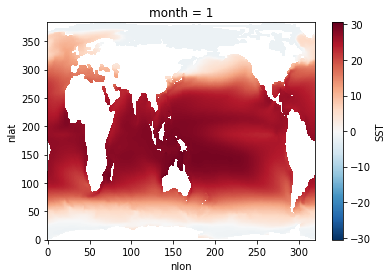

In [8]:
ds_clim.SST.sel(month=1).plot()

####  Simple Hovmoller plot

/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


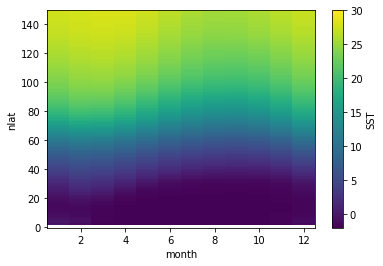

In [11]:
ds_clim.SST.isel(nlat=slice(0, 150)).mean(dim='nlon').T.plot(vmin=-2, vmax=30)

## Clip it down to the Southern Ocean

In [12]:
masked_clim = ds_clim.where((ds.TLAT <= -45) & (ds.KMT > 0))

#### Plot SST and then Chl

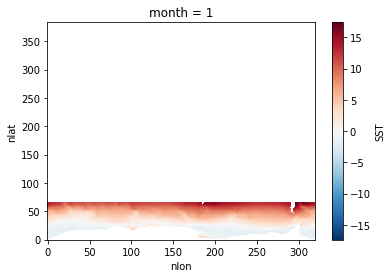

In [13]:
#Plot One:
masked_clim.SST.sel(month=1).plot()

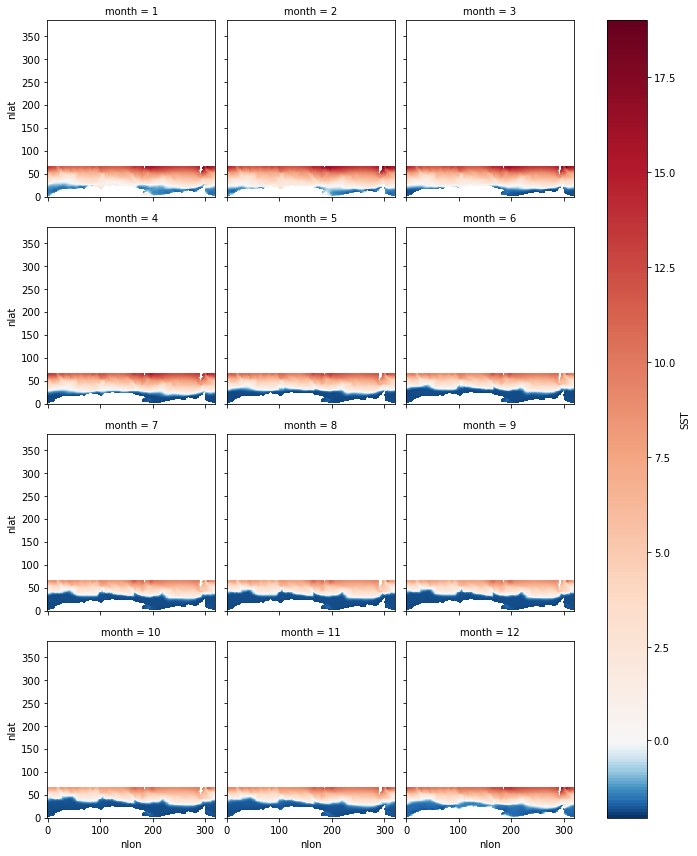

In [14]:
#Plot All!
import matplotlib.colors as colors
# make the norm:  Note the center is offset so that the land has more
# dynamic range:
divnorm = colors.DivergingNorm(vmin=-2., vcenter=0, vmax=19)

masked_clim.SST.plot(col="month", col_wrap=3,
                     norm=divnorm, cmap = 'RdBu_r')

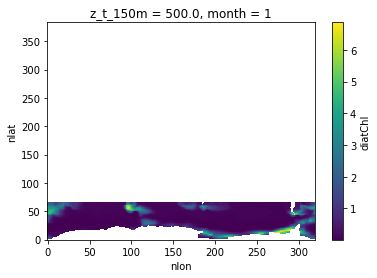

In [15]:
ds_chl = masked_clim.diatChl.isel(z_t_150m=0)
#masked_clim.diatChl.isel(month=0, z_t_150m=0).plot()
ds_chl.sel(month=1).plot()

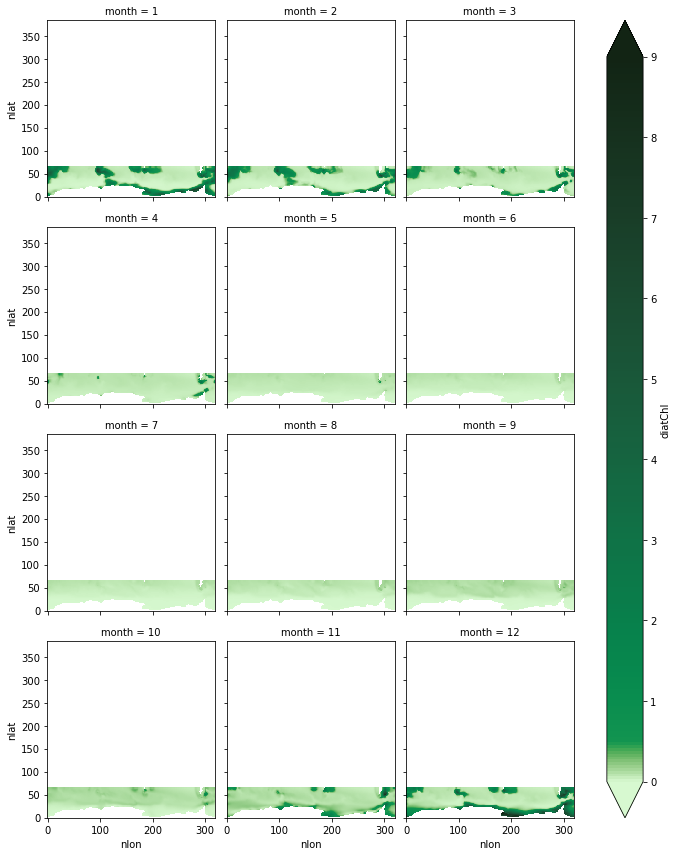

In [16]:
#Plot All!
import cmocean
import cmocean.cm as cmo

divnorm = colors.DivergingNorm(vmin=0, vcenter=0.5, vmax=9)

masked_clim.diatChl.isel(z_t_150m=0).plot(col="month", col_wrap=3,
                                          norm=divnorm, cmap = 'cmo.algae')

### Hovmoller Plots of Southern Ocean

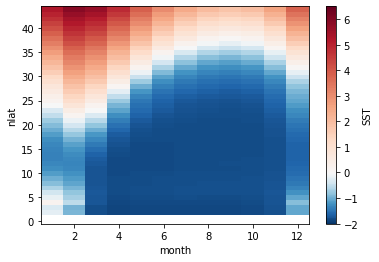

In [17]:
divnorm = colors.DivergingNorm(vmin=-2, vcenter=0, vmax=6.5)


masked_clim.SST.isel(nlat=slice(0, 45)).mean(dim='nlon').T.plot(norm=divnorm, cmap = 'RdBu_r')

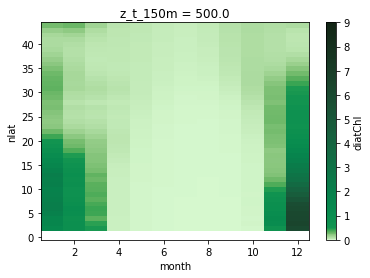

In [18]:
#ds_chl.isel(nlat=slice(0, 45)).mean(dim='nlon').T.plot()
divnorm = colors.DivergingNorm(vmin=0, vcenter=0.5, vmax=9)
masked_clim.diatChl.isel(z_t_150m=0,nlat=slice(0, 45)).mean(dim='nlon').T.plot(norm=divnorm, cmap = 'cmo.algae')

##### From Initial Tasks Issue:
Chl =  (diatChl + spChl).isel(z_t_150m=0)
#### why?


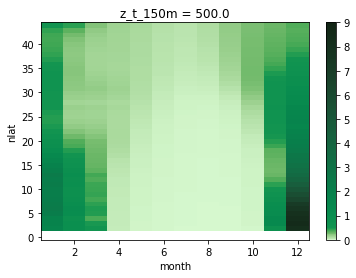

In [19]:
Chl = (masked_clim.diatChl + masked_clim.spChl).isel(z_t_150m=0)
#plot what you want:
#Chl.isel(nlat=slice(0, 45)).mean(dim='nlon').T.plot()
#Chl.sel(month=1).plot()

#ds_chl.isel(nlat=slice(0, 45)).mean(dim='nlon').T.plot()
divnorm = colors.DivergingNorm(vmin=0, vcenter=0.5, vmax=9)
Chl.isel(nlat=slice(0, 45)).mean(dim='nlon').T.plot(norm=divnorm, cmap = 'cmo.algae')

## Calculating Daily Growth Rate

In [20]:
# Set Constants
a = -0.066 #alpha
b = 0.002 #beta
c = -0.000061 #gamma
d = 0.385 #delta
e = 0.328 #epsilon
f = 0.0078 #zeta
g = -0.0101 #eta

In [21]:
#Set up data to use:
chl = Chl
sst = masked_clim.SST

#Create Length Array
L_i = xr.full_like(masked_clim['SST'], 40)
L_i.name = 'length'
L_i.attrs = ''
masked_clim['L_i'] = L_i

In [22]:
daily_growth_rate = a + (b * masked_clim.L_i
                        ) + (c * masked_clim.L_i**2) + ((d * Chl) / (e + Chl)
                                                       ) + (f * sst) + (g * sst**2) + masked_clim.L_i

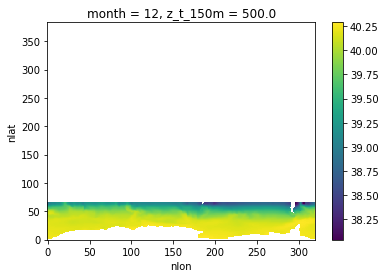

In [23]:
daily_growth_rate = daily_growth_rate.compute()
#test:
daily_growth_rate.sel(month = 12).plot()

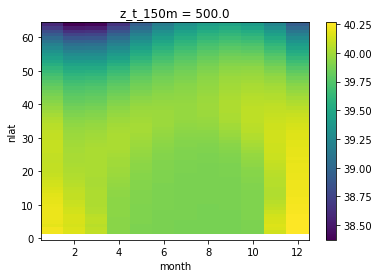

In [28]:
daily_growth_rate.isel(nlat=slice(0, 65)).mean(dim='nlon').T.plot()

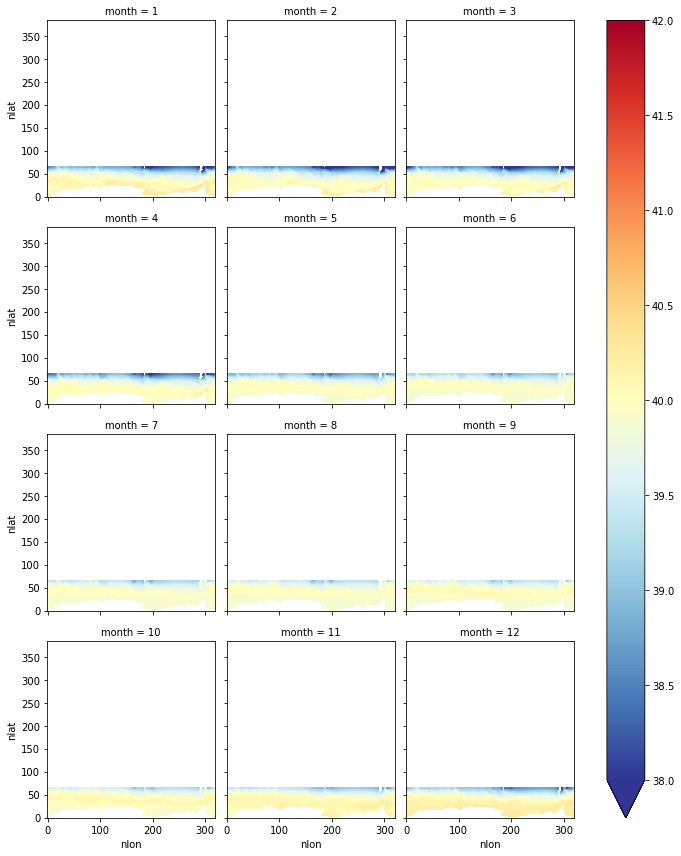

In [30]:
#Plot All!
divnorm = colors.DivergingNorm(vmin=38, vcenter=40, vmax=42)

daily_growth_rate.plot(col="month", col_wrap=3,norm = divnorm, cmap = 'RdYlBu_r')

In [31]:
delta_growth_rate = daily_growth_rate.sel(month=3) - daily_growth_rate.sel(month=11) # last time step minus first.

In [39]:
daily_growth_rate.mean.plot()

AttributeError: 'function' object has no attribute 'plot'

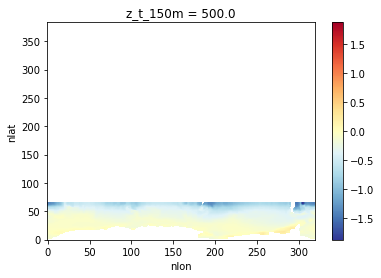

In [32]:
#delta_growth_rate.plot.contourf()
delta_growth_rate.plot(cmap = 'RdYlBu_r')

/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


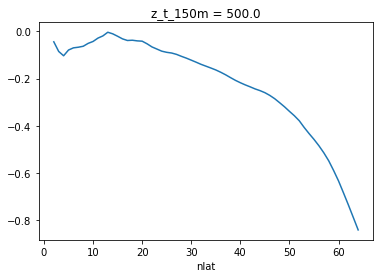

In [33]:
delta_growth_rate.isel(nlat=slice(0, 65)).mean(dim='nlon').T.plot()

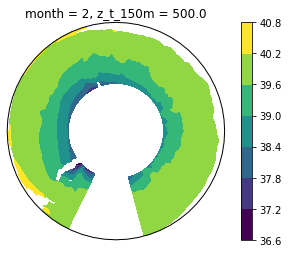

In [41]:
ax = plt.axes(projection=ccrs.Orthographic(-15, 90))
daily_growth_rate.isel(month=1).plot.contourf(ax=ax,
                                              transform=ccrs.PlateCarree());
#Chl.isel(month=0).plot.contourf(ax=ax, transform=ccrs.NorthPolarStereo());
#ax.set_global(); ax.coastlines();

___
Not sure what this is...
but it's an example from https://rabernat.github.io/research_computing/xarray.html

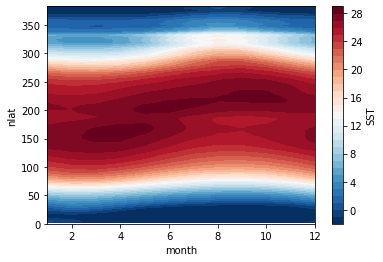

In [22]:
ds_clim.SST.mean(dim='nlon').T.plot.contourf(levels=np.arange(-2,30))
#masked_clim.SST.mean(dim='nlon').T.plot.contourf(levels=np.arange(-2,30))

 and does this make what I've done wrong?


___
initial data explore items
___

## visualize land mask
KMT is the k index of the models lowest level. We can use this variable to visualize the land mask.

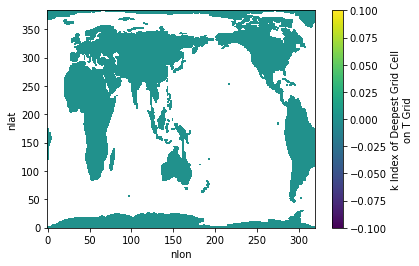

In [8]:
ds.KMT.where(ds.KMT==0).plot()

## take a peak at SST variable


In [9]:
ds.SST

<xarray.DataArray 'SST' (time: 1872, nlat: 384, nlon: 320)>
dask.array<getitem, shape=(1872, 384, 320), dtype=float32, chunksize=(1872, 384, 16), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-17 00:30:00 ... 2005-12-16 12:00:00
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Potential Temperature
    units:         degC
    coordinates:   TLONG TLAT z_t time
    grid_loc:      3111
    cell_methods:  time: mean

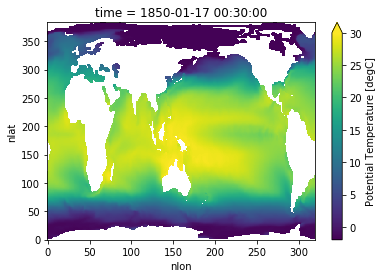

In [10]:
ds.SST.isel(time=0).plot(vmin=-2, vmax=30)

### Compute the area-weight mean SST in the Southern Ocean. 
First we need the cell-area:



In [ ]:
ds.TAREA

##### Construct a mask

In [20]:
masked_area = ds.TAREA.where((ds.TLAT <= -45) & (ds.KMT > 0))
masked_area
#masked_area.plot()

<xarray.DataArray 'TAREA' (nlat: 384, nlon: 320)>
dask.array<where, shape=(384, 320), dtype=float64, chunksize=(384, 16), chunktype=numpy.ndarray>
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:    area of T cells
    units:        centimeter^2
    coordinates:  TLONG TLAT

take the sum of (SST * area of SO) along the grid, divide it by the sum of the area in the grid

In [13]:
sst_so_mean = (ds.SST * masked_area).sum(['nlat', 'nlon']) / masked_area.sum(['nlat', 'nlon'])
sst_so_mean = sst_so_mean.compute()
sst_so_mean

<xarray.DataArray (time: 1872)>
array([4.60991911, 5.20071189, 5.00448381, ..., 2.39221257, 2.97647497,
       4.13876487])
Coordinates:
  * time     (time) object 1850-01-17 00:30:00 ... 2005-12-16 12:00:00

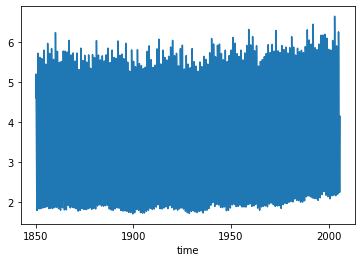

In [14]:
sst_so_mean.plot()

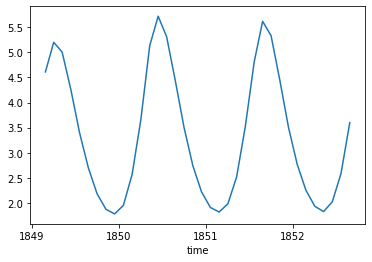

In [15]:
sst_so_mean.isel(time=slice(0, 36)).plot()

In [16]:
diatChl_so_mean = (ds.diatChl.isel(z_t_150m=0) * masked_area).sum(['nlat', 'nlon']) / masked_area.sum(['nlat', 'nlon'])
diatChl_so_mean = diatChl_so_mean.compute()
diatChl_so_mean

<xarray.DataArray (time: 1872)>
array([0.6075989 , 0.42885908, 0.24924154, ..., 0.12752425, 0.26818996,
       0.678102  ])
Coordinates:
    z_t_150m  float32 500.0
  * time      (time) object 1850-01-17 00:30:00 ... 2005-12-16 12:00:00

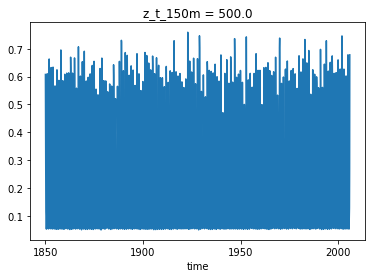

In [17]:
diatChl_so_mean.plot()

In [20]:
cluster.close()
client.close()